In [5]:
import h5py
import numpy as np
import pandas as pd
import tables
import os
import sys
import time
import glob
import scipy.io as sio
import hdf5_getters
from pandas import read_hdf
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense

from sklearn.metrics import mean_squared_error
import matplotlib as plt

In [6]:
finalWorkingDF = pd.read_pickle("finalWorkingDF")

finalWorkingDF = finalWorkingDF[finalWorkingDF.year != 0]
finalWorkingDF.fillna(finalWorkingDF.mean(), inplace=True)

classifierData = finalWorkingDF
classifierData['year'] = np.floor(classifierData['year']/10)*10


In [7]:
# Separate data into training and testing set
y = finalWorkingDF['year']
x = finalWorkingDF.drop('year', axis = 1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

y_classify = classifierData['year']
x_classify = classifierData.drop('year', axis = 1)
x_classify_train, x_classify_test, y_classify_train, y_classify_test = train_test_split(x_classify, y_classify, test_size=0.2)
classes = np.unique(classifierData['year'])

In [8]:
# x_train.to_pickle("XTrain")
# y_train.to_pickle("YTrain")
# x_test.to_pickle("XTest")
# y_test.to_pickle("YTest")

In [9]:
###################### REGRESSION NEURAL NETWORK ########################
# nCols = x_train.shape[1]
# # create model
# model = Sequential()
# #model.add(Dense(12, input_shape=(3744,37), activation='relu'))
# model.add(Dense(12, input_shape=(nCols,), activation='relu'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation='relu'))

# # Compile model
# model.compile(loss='mean_squared_error', optimizer='adam')

# # Fit the model
# model.fit(x_train.to_numpy(), y_train.to_numpy(), epochs=150, batch_size=10)

# # evaluate the model
# train_scores = model.evaluate(x_train, y_train)
# #print("\n%s: %.2f%%" % (model.metrics_names[1], train_scores[1]*100))
# test_scores = model.evaluate(x_test, y_test)
# #print("\n%s: %.2f%%" % (model.metrics_names[1], test_scores[1]*100))

# ###################### Neural Network Analysis ########################
# print(model.evaluate(x_train, y_train))
# print(model.evaluate(x_test, y_test))

In [10]:
###################### CLASSIFICATION NEURAL NETWORK ########################
# import keras
# from keras.layers import Dense, Dropout, Activation
# from keras.optimizers import SGD
# from sklearn.preprocessing import LabelEncoder
# from keras.utils import np_utils

# # encode class values as integers
# encoderTrain = LabelEncoder()
# encoderTrain.fit(y_classify_train)
# encoderTrainY = encoder.transform(y_classify_train)
# # convert integers to dummy variables (i.e. one hot encoded)
# dummy_y_train = np_utils.to_categorical(encoderTrainY)

# # encode class values as integers
# encoderTest = LabelEncoder()
# encoderTest.fit(y_classify_test)
# encoderTestY = encoder.transform(y_classify_test)
# # convert integers to dummy variables (i.e. one hot encoded)
# dummy_y_test = np_utils.to_categorical(encoderTestY)

# nCols = x_classify_train.shape[1]


# model.add(Dense(64, activation='relu', input_dim=nCols))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(10, activation='softmax'))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(loss='categorical_crossentropy',
#               optimizer=sgd,
#               metrics=['accuracy'])

# model.fit(x_classify_train.to_numpy(), dummy_y_train, epochs=20, batch_size=128)
# score = model.evaluate(x_classify_test.to_numpy(), dummy_y_test, batch_size=128)
# print(score)
# print(neural_network.predict(x_classify_test.to_numpy()[0:10], batch_size=32, verbose=0))


# 10-701 Song Project

## Introduction

For this project, we are exploring the capabilities of musical factors and song lyrics the year a song was released. In particular we are looking at the 10,000 song subset of the million song dataset and the musixmatch dataset for the 10,000 song subset. The 10,000 song subset contains very detailed information with many dimensions about each song such as timbre and pitch vectors for each segment of the song, tatums, loudness and various other algorithmically determined factors such as artist hotness, song hotness, danceability, etc. In contrast, the musixmatch dataset only contains bag-of-words lyrics for each song. Our goal is to determine whether models predicting a song's release year trained on the musixmatch dataset can exhibit similar testing performance as models trained on the full feature-set of the 10k subset.

## Background/Literature

In Singhi's and Brown's "Hit Song Detection using Lyrics Features Alone", they explore the problem of whether songs can be predicted to be hits or flops based on lyrics alone. They trained a Bayesian network with 492 hits and 6323 flops, with recall and precision accuracies of 0.451 and 0.214 respectively. This is relevant to our problem because for a model predicting year solely by lyrics, lyrical content/sentiment analysis will not be enough for the model to be robust, because many songs across decades have similar topics. We will need to analyze and extract other features of our data that will correlate more with year. In Singhi's and Brown's paper, they use the "Rhyme Analyzer", an analysis tool for rap lyrics developed by H. Hirjee and D.G. Brown. The also use the CMU Prounouncing Dictionary to identify the fraction of lines written in iambic, trochaic, spondaic, etc. meters. We cannot directly use the same tools because our dataset is in a bag-of-words format, so we don't have distinct lines to analyze. However, for the final project, we will explore creating a variant of these tools or use similar ideas to get features from our data. This will likely help us increase our model's accuracy.

Another important part of making our models robust is choosing the features our models will train on carefully. One of the papers that helped us decide is "Feature Selection for High Dimensional Data: A Fast Correlation-Based Filter Solution" by L. Yu and H. Liu. This paper describes assigning a measure of goodness to each feature to maximize relevance to the class concept and minimize redudance to every other relevant feature. To quantize these measures, they introduce a new term, symmetrical uncertainty (SU), based on information gain between two random variables. To decide whether a feature is sufficiently relevant to the class or not, they propose setting a user-defined SU value such that if a feature's symmetrical uncertainty with the whole class is greater than the threshold, it is considered relevant. To determine redudance between features, they define a new concept called predominance correlation where a relevant feature is considered redudant if there exists another feature with which each its symmetrical uncertainty is greater than that of with the class. Exploring various methods of feature selection will help streamline our model.

The paper "Lyric Text Mining in Music Mood Classification" by X. Hu, J. Downie, and A. Ehmann explores a similar problem to our own. Their objective was to compare and contrast music mood classification models trained on audio features vs. lyric text features. This is somewhat similar to our objective because our base model (the one using all features provided by the 10k subset) mainly uses audio features to make predictions but our test model (the one using the bag-of-words data) has no data about the raw audio, just the spoken words in the song. However, the paper explores classifying music mood rather than release year. Despite that, their support vector machine model gave us valuable information that we could work into our own implementations. For example, they performed their own cleaning on the bag-of-words data to make sure each song had associated words that were representative of the song. How to do this in our case can be explored in several ways: for example, we can naively remove all occurrences of "meaningless" words like "the", "of", etc. 

To further make our bag-of-words model robust, some form of sentiment analysis is required. In a way, that is already essentially what our models are doing, except instead of classifying mood, we classify year. Therefore, instead of picking on lyrical cues that give away the sentiment, we instead learn to weight words that are common in a particular year, etc. "Delta TFIDF: An Improved Feature Space for Sentiment Analysis" by J. Martineau and T. Finin describes a novel method of performing sentiment analysis on bag-of-words data, of which some ideas can be adapted for our own models. For example, the paper justifies their use of a linear kernel by reasoning that sentiment analysis is a linearly separable problem and that linear kernels typically yield higher acccuracy for most variations of bag-of-words sets.  


## Methods/Model

### Preliminary Data Analysis and Feature Extraction

We used a 10,000 song subset of the Million Song Dataset for our analysis, since the million songs would have taken much to long to run and was too large to store locally on our computers. We downloaded the 10,000 song subset which had the data for each song represented as a HDF5 file. We scripted through this dataset, extracting out each songs features and converting the data into a pandas dataframe. We then removed every song in the dataframe that had a year value of 0, which indicated that the database did not have the year recorded for that song. In order to make our predictive models that used the musical qualities of a song to predit the year it was released, we dropped features from the dataframe that were unrelated to the musical qualities for the songs such as "artist_familiarity", "artist_location", "track_id", "artist_id", etc. Confidence values for song features were also included in the dataset such as "bars_confidence", "beats_confidence","key_confidence", etc. which we also decided to remove, however the impacts of retaining these variables will be examined in the final paper. The dataframe also included two-dimensional arrays that listed 12 dimensional timbre and pitch vectors at each point in the song. In order to make these two-dimensional vectors readable to our machine learning algorithms, we took the weighted average of the 12 dimensional timbre and pitch vectors based on how long that pitch/timbre lasted before the onset of another pitch/timbre vector given by the "segments_start" variable. We then set each value in new 12-dimensional timbre and pitch vectors to represent a new feature, so we now had 12 features for timbre and 12 for pitch for every song. 

As you can see though by displaying the covariances between each of the variables, the transformed pitch values are very highly correlated with each of the corresponding transformed timbre values.


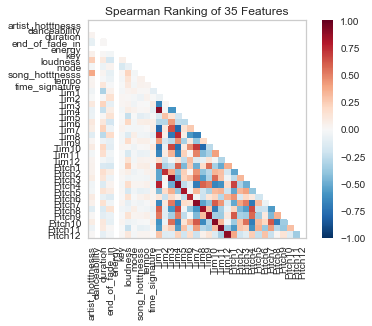

In [13]:
###################### Covariance Analysis ########################
from yellowbrick.features import Rank2D

visualizer = Rank2D(algorithm="spearman")
visualizer.fit_transform(x)
visualizer.poof()

However, when graphing the Pitch12 and Timber12 values which are viewed as highly correlated, there does not seem to be that much of a relation between them.

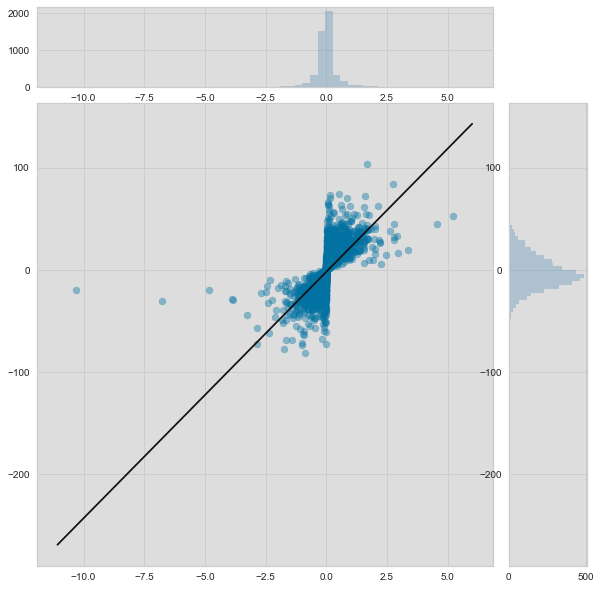

In [18]:
###################### More Covariance Analysis Between Pitch1 and Timber1 ########################

from yellowbrick.features import JointPlotVisualizer

visualizer = JointPlotVisualizer(feature='Tim1', target='Pitch1')
visualizer.fit(x['Tim12'], x['Pitch12'])
visualizer.poof()

We also remove the "sections_start" and "tatums_start" variables in the dataset which represented the times where the largest grouping and smallest grouping respectively in a song would begin because we only used the weighted average of the pitches and timbre vectors, so this information would not be useful. One of the most difficult aspects of this project was examining the data and seeing which predictors to include in our models and how we shoould include certain variables in thee model. This is what makes using lyrics to predict year instead much more simple, which was the impetus for this project. We also hope to examine using the song information differently such as using the "sections_start" and "tatums_start" to extract out the most important timbre and pitch vectors in a song. In addition, when a song does not have information for a certain variable, we input the mean of that feature, so that we don't throw out so much data since there are so many variables that could be empty.

### Preliminary Models

We used extracted data to make k nearest neighbor, ridge and lasso linear regression, and support vector regression to attempt and get the exact year a song was released.

We also created k nearest neighbor, random forest, logistic regression, support vector machine, and naive bayes classifiers that predict the decade a song came out.


In [19]:
###################### KNN REGRESSION ########################
n_neighbors = 15

nnRegressor = neighbors.KNeighborsRegressor(n_neighbors)
nnRegressor.fit(x_train, y_train)

# Get training and test predictions
predictedtrainyears = nnRegressor.predict(x_train)
trainMSE = mean_squared_error(y_train, predictedtrainyears)
testMSE = mean_squared_error(y_test, nnRegressor.predict(x_test))

print("training MSE", trainMSE)
print("testing MSE", testMSE)

training MSE 116.95880816714153
testing MSE 121.83095916429245


In [22]:
###################### RIDGE LINEAR REGRESSION (REGULARIZER FIT WITH CV)########################
from sklearn import linear_model
regRidge = linear_model.RidgeCV(alphas=[0.1, 1.0, 10.0], cv=3)
regRidge.fit(x_train, y_train)
#RidgeCV(alphas=[0.1, 1.0, 10.0], cv=3, fit_intercept=True, scoring=None, normalize=False)

# Get training and test predictions
predictedtrainyears = regRidge.predict(x_train)
trainMSE = mean_squared_error(y_train, predictedtrainyears)
testMSE = mean_squared_error(y_test, regRidge.predict(x_test))

print("training MSE", trainMSE)
print("testing MSE", testMSE)

training MSE 123.22214133996816
testing MSE 105.24366082432529


In [36]:
###################### LASSO LINEAR REGRESSION ########################
regLasso = linear_model.Lasso(alpha=0.1)
regLasso.fit(x_train, y_train)
#Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000, 
#normalize=False, positive=False, precompute=False, random_state=None, 
#selection='cyclic', tol=0.0001, warm_start=False)

# Get training and test predictions
predictedtrainyears = regLasso.predict(x_train)
trainMSE = mean_squared_error(y_train, predictedtrainyears)
testMSE = mean_squared_error(y_test, regLasso.predict(x_test))

print("training MSE", trainMSE)
print("testing MSE", testMSE)

training MSE 123.5165156060086
testing MSE 105.11175813774928


In [34]:
###################### SVM REGRESSION ########################
from sklearn import svm

# Apparently SVMs also do regression 
clf = svm.SVR(gamma='auto_deprecated', kernel='rbf')
clf.fit(x_train, y_train) 

# Get training and test predictions
predictedtrainyears = clf.predict(x_train)
trainMSE = mean_squared_error(y_train, predictedtrainyears)
testMSE = mean_squared_error(y_test, clf.predict(x_test))

print("training MSE", trainMSE)
print("testing MSE", testMSE)

/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


training MSE 169.95308552898308
testing MSE 156.90143803924627


The linear model performed the best for our regression models. We choose to investigate the predictions of the lasso regression model on the test set since the model's cross validated MSE is so similar to the ridge regression model and lasso regression creates a sparser model. We get the following residual plot and prediction error plot by predictions for the lasso regression linear model.

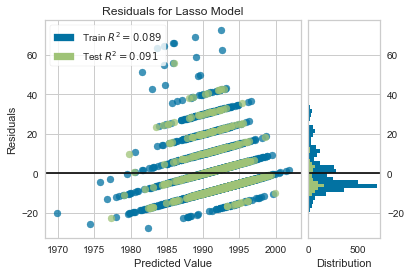

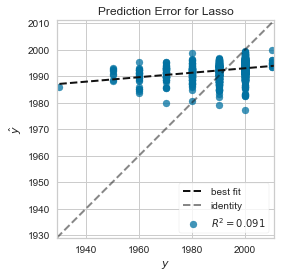

In [45]:
###################### Residuals by Prediction (Linear LASSO) ########################
visualizer = ResidualsPlot(linear_model.Lasso())
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)
visualizer.poof()

# Instantiate the linear model and visualizer
visualizer2 = PredictionError(linear_model.Lasso())
visualizer2.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer2.score(x_test, y_test)  # Evaluate the model on the test data
visualizer2.poof()             # Draw/show/poof the data

In [60]:
###################### KNN CLASSIFIER ########################
n_neighbors = 15

nnClassifier = neighbors.KNeighborsClassifier(n_neighbors)
nnClassifier.fit(x_classify_train, y_classify_train)

# Get training and test predictions
predictedtrainyears = nnClassifier.predict(x_classify_train)
trainMSE = mean_squared_error(y_classify_train, predictedtrainyears)
testMSE = mean_squared_error(y_classify_test, nnClassifier.predict(x_classify_test))
# classifier_trainMSE = np.mean((nnClassifier.predict(x_trainNumPy) - y_trainNumPy)**2)
# classifier_testMSE = np.mean((nnClassifier.predict(x_testNumPy) - y_testNumPy)**2)

#print("training MSE", trainMSE)
#print("testing MSE", testMSE)

nnClassifier.score(x_classify_test, y_classify_test)

0.5042735042735043

In [59]:
###################### LOGISTIC REGRESSION ########################

#LogisticRegression(multi_class='multinomial',solver ='newton-cg').fit(x_classify_train, y_classify_train)
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(solver='newton-cg', multi_class='multinomial').fit(x_classify_train, y_classify_train)
clf.predict(x_classify_test)
clf.predict_proba(x_classify_test) 
clf.score(x_classify_test, y_classify_test)



/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


0.532051282051282

In [66]:
###################### SUPPORT VECTOR MACHINE MODELS ########################

# RBF Kernel
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(x_classify_train, y_classify_train) 
#SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
#    decision_function_shape='ovo', degree=3, gamma='scale', kernel='rbf',
#    max_iter=-1, probability=False, random_state=None, shrinking=True,
#    tol=0.001, verbose=False)
print(clf.score(x_classify_test, y_classify_test))

# Linear Kernel
lin_clf = svm.LinearSVC()
lin_clf.fit(x_classify_train, y_classify_train) 
#LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#     verbose=0)
print(lin_clf.score(x_classify_test, y_classify_test))

0.5405982905982906
0.08012820512820513


/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [68]:
###################### Gaussian Naive Bayes ########################
from sklearn.naive_bayes import GaussianNB

# Instantiate the classification model and visualizer
bayes = GaussianNB()
bayes.fit(x_classify_train, y_classify_train) 
print(bayes.score(x_classify_test, y_classify_test))


0.18696581196581197


In [73]:
###################### Random Forest ########################

from sklearn.ensemble import RandomForestClassifier

randForest = RandomForestClassifier(n_estimators=100)
randForest.fit(x_classify_train, y_classify_train)
print(randForest.score(x_classify_test, y_classify_test))


0.5470085470085471


In [83]:
############ COMMON SENSE ANALYSIS ###################
from scipy import stats
modeN = stats.mode(y_classify_test)[0][0]
naivePreds = np.repeat(modeN, len(y_classify_test))

print(sum(np.equal(naivePreds,y_classify_test))/len(y_classify_test))

0.5395299145299145


Our best classifier turns out to be the random forest model, however it seems that if you were naively to guess that every song was released in the year 2000, you would be correct 53.95% of the time for our test data. Whereas the random forest does only slightly better for the test data with 54.70% of the test data being classified correctly.

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


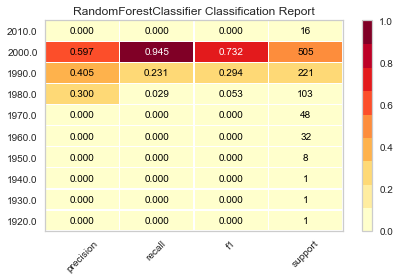

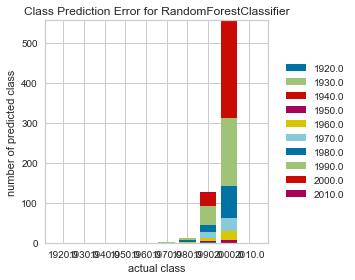

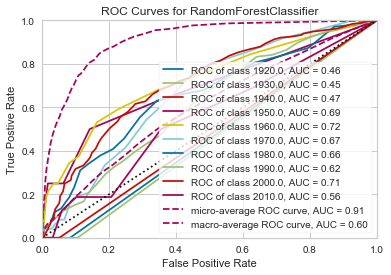

In [86]:
###################### Classifier Graphs and Diagnostics for Random Forest Model ########################
import yellowbrick
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassPredictionError

#######Classification Report
visualizer1 = ClassificationReport(RandomForestClassifier(n_estimators=100), classes=classes, support=True)
visualizer1.fit(x_classify_train, y_classify_train)
visualizer1.score(x_classify_test, y_classify_test)
visualizer1.poof()

#######Classifier Probabilities for Random Forest

visualizer2 = ClassPredictionError(RandomForestClassifier(n_estimators=100), classes=classes)
visualizer2.fit(x_classify_train, y_classify_train)
visualizer2.score(x_classify_test, y_classify_test)
visualizer2.poof()


#######ROC Curve for Random Forest

visualizer3 = yellowbrick.classifier.rocauc.ROCAUC(RandomForestClassifier(n_estimators=100), classes=classes)

visualizer3.fit(x_classify_train, y_classify_train)  # Fit the training data to the visualizer
visualizer3.score(x_classify_test, y_classify_test)  # Evaluate the model on the test data
visualizer3.poof()             # Draw/show/poof the data

In [88]:
################## MSE FOR RANDOM FOREST VS MSE OF LASSO REGRESSION ##############
regLasso = linear_model.Lasso(alpha=0.1)
regLasso.fit(x_train, y_train)
#Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000, 
#normalize=False, positive=False, precompute=False, random_state=None, 
#selection='cyclic', tol=0.0001, warm_start=False)

# Get training and test predictions
predictedtrainyears = regLasso.predict(x_train)
trainMSE = mean_squared_error(y_train, predictedtrainyears)
testMSE = mean_squared_error(y_test, regLasso.predict(x_test))

print("Lasso training MSE", trainMSE)
print("Lasso testing MSE", testMSE)

randForest = RandomForestClassifier(n_estimators=100)
randForest.fit(x_classify_train, y_classify_train)

trainMSE = mean_squared_error(y_train, randForest.predict(x_classify_train))
testMSE = mean_squared_error(y_test, regLasso.predict(x_classify_test))

print("Random Forest training MSE", trainMSE)
print("Random Forest testing MSE", testMSE)

Lasso training MSE 123.5165156060086
Lasso testing MSE 105.11175813774928
Random Forest training MSE 269.15064102564105
Random Forest testing MSE 131.76560900325705


It seems as though regression may suit this problem more since the proportion of songs in the validation set with correctly classified song release decades is very low. In addition, when comparing the mean squared error of the classifiers and the regression model, it seems as though the classifier was not doing considerably better despite having an easier problem to solve with only 10 decades to choose from.

## Future Work

For our baseline models we performed a very naive form of feature extraction and selection, where we manually decided if a feature would be relevant to a model's performance or not. For example, features like "artist_familiarity", "artist_id", "artist_location" are very loosely related to a song's release year, and so we decided to remove them. Other features such as "tatums_start", "segments_start", "segments_timbre" and "segments_pitches" features were arrays for each song and to run classifiers on them, we decided to resolve on ways to condense them down into single numbers. For example, we used the "segments_start" and "segments_end" to coalesce into one feature for average segment length. Other examples of manual feature manipulation are described in the preliminary data analysis section, but our approach is naive for several reasons.

One problem is that we completely disregard non-numeric features such as "title", "similar_artists", "artist_name" and "artist_terms" which are theoretically highly correlated with a song's release year. A sophisticated model could develop a "cache" of artist names that are correlated with song release years/decades and that would highly increase accuracy. Similarly, it could create a cache for terms that are associated with artists and use the similar artists list to compare with its cache and see if all the similar artists are clustered around a particular time, narrowing down its choices. These ideas, however, only apply if our goal is to create a model that uses all dimensions as effectively as possible rather than solely by features that are directly contrived from the musical qualities of the song. 

Another reason we could improve our feature extraction is to use the correlation-based feature extraction mentioned in the background section of this paper. This will help us focus on key features that maximize correlation with the class but also minimize redudance with each other. One particular example where this would come in handy is with the pitch and timbre vectors. Pitch i and timbre i for all i are highly correlated with each other as seen in our correlation plot in the first figure. Therefore it may make sense to remove one of the timbre or pitch vectors, and to decide, we have to perform the aforementioned symmetric uncertainty filtration.

One of the problems with our data seems to be its concentration in the 2000-decade. This is seen most clearly in our random forest classifier model, which, despite being the best classifier, only does marginally better than a naive model which predicts the 2000 decade every time. To prevent this, additional analysis must be done to see which features tend to separate the 2000 decade from other decades.

## TALK ABOUT TIMELINE AND WORK DIVISION HERE

## ALSO CHECK IF ITS 3 PAGES


## Teammates and work division

Michael Kronovet did the majority of the data processing and feature selection. He also fit the k nearest neighbor models, linear regression models, support vector machines, the random forest model, the logistic regression model, and naive bayes classifier that predict the decade a song came out. He also created the evaluation plots for the best classifier and best regressor model.

Tanishq Kancharla did much of the research of similar problems and helped select features for baseline models. For example, he helped decide how the pitch and timbre vectors should be interpreted in our data. Incorporating research articles and baseline model data, he also describes various ways and techniques to make models more accurate and robust in the future work section.

## Citations
    Hu, Xiao, J. Stephen Downie, and Andreas F. Ehmann. "Lyric text mining in music mood classification." American music 183.5,049 (2009): 2-209.
    Martineau, Justin, AND Finin, Tim. "Delta TFIDF: An Improved Feature Space for Sentiment Analysis" International AAAI Conference on Web and Social Media (2009): n. pag. Web. 11 Mar. 2019
    Yu, Lei, and Huan Liu. "Feature selection for high-dimensional data: A fast correlation-based filter solution." Proceedings of the 20th international conference on machine learning (ICML-03). 2003.
    Singhi, Abhishek, and Daniel G. Brown. "Hit song detection using lyric features alone." Proceedings of International Society for Music Information Retrieval (2014).